<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset fijo y online: Fashion-MNIST lo descarga Keras automáticamente, así todos tienen los mismos datos.

MLP (capas densas): no usamos convoluciones para mantenerlo simple.

Preprocesado mínimo: normalizar a [0,1] y aplanar imágenes a vectores de 784 píxeles.

Buenas prácticas sin liarla: EarlyStopping, conjunto de validación estratificado, curvas de aprendizaje y reporte de métricas.

Reproducibilidad: se fija semilla global; en DL puede no ser 100% idéntico en todas las máquinas, pero será muy similar.

In [2]:
!pip install tensorflow scikit-learn matplotlib

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6878 - loss: 0.8937 - val_accuracy: 0.8484 - val_loss: 0.4254
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8365 - loss: 0.4550 - val_accuracy: 0.8676 - val_loss: 0.3685
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8558 - loss: 0.4018 - val_accuracy: 0.8733 - val_loss: 0.3502
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8653 - loss: 0.3712 - val_accuracy: 0.8792 - val_loss: 0.3366
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8709 - loss: 0.3511 - val_accuracy: 0.8799 - val_loss: 0.3317
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8751 - loss: 0.3378 - val_accuracy: 0.8845 - val_loss: 0.3281
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5

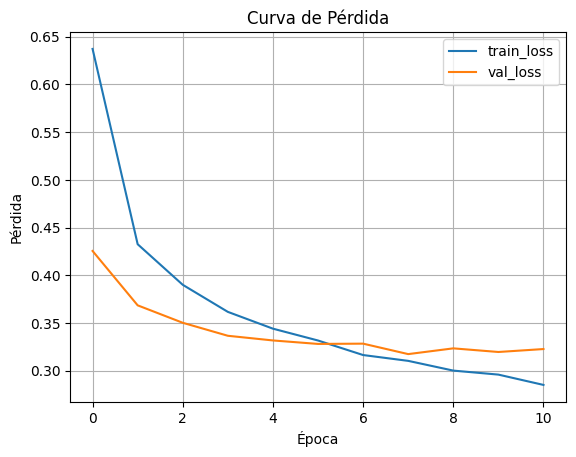

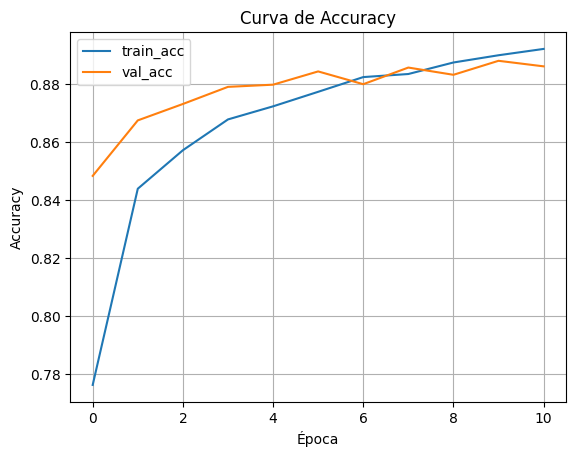

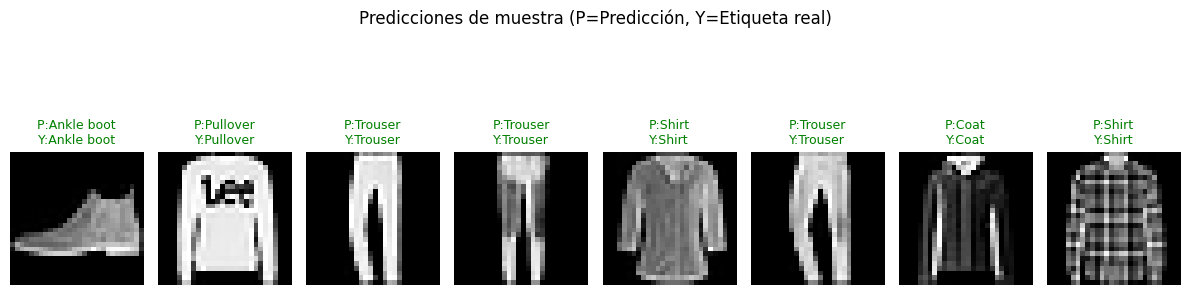

In [3]:
"""
MLP para Dummies — Entrenamiento end-to-end con Fashion-MNIST
-------------------------------------------------------------
- Dataset: Fashion-MNIST (10 clases de ropa; 60k train / 10k test).
- Modelo: MLP sencillo (capas densas).
- Objetivo: que cualquiera pueda ejecutar y ver un flujo completo de DL.

Cómo ejecutar:
    python mlp_fashion_mnist.py

Autor: Tú :)
"""

import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Métricas extra
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# ---------------------------------------------------------------------
# 0) Reproducibilidad (opcional pero recomendado)
# ---------------------------------------------------------------------
def set_global_seed(seed: int = 42):
    """
    Fija semillas para intentar resultados reproducibles.
    Nota: En DL puede haber pequeñas variaciones según hardware/versión.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    # Opcional: forzar determinismo en TF si está disponible (TF >= 2.12)
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# ---------------------------------------------------------------------
# 1) Carga y preparación de datos
# ---------------------------------------------------------------------
def load_and_preprocess_data(test_size: float = 0.2, seed: int = 42):
    """
    Descarga Fashion-MNIST, normaliza a [0,1], aplana imágenes a vectores,
    y separa un conjunto de validación a partir del train (estratificado).
    """
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    # Normalizar a [0,1]
    X_train_full = X_train_full.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Aplanar imágenes 28x28 -> 784 (para MLP)
    X_train_full = X_train_full.reshape((X_train_full.shape[0], -1))
    X_test = X_test.reshape((X_test.shape[0], -1))

    # Split train -> train + val, estratificado para mantener proporciones de clase
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=test_size,
        random_state=seed,
        stratify=y_train_full
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# ---------------------------------------------------------------------
# 2) Construcción del modelo MLP
# ---------------------------------------------------------------------
def build_mlp(input_dim: int, num_classes: int = 10) -> keras.Model:
    """
    MLP sencillo:
      - Capa densa 128 neuronas + ReLU
      - Dropout 0.2 (ayuda a evitar sobreajuste)
      - Capa densa 64 neuronas + ReLU
      - Capa de salida softmax (10 clases)
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model


# ---------------------------------------------------------------------
# 3) Entrenamiento
# ---------------------------------------------------------------------
def train(model: keras.Model, X_train, y_train, X_val, y_val, epochs: int = 20, batch_size: int = 128):
    """
    Compila y entrena el modelo con EarlyStopping.
    """
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,              # si en 3 épocas no mejora, paramos
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return history


# ---------------------------------------------------------------------
# 4) Evaluación y reporte
# ---------------------------------------------------------------------
def evaluate_and_report(model: keras.Model, X_test, y_test):
    """
    Evalúa en test, muestra accuracy y un reporte de clasificación.
    """
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n=== Resultados en TEST ===")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión (valores absolutos):")
    print(cm)


# ---------------------------------------------------------------------
# 5) Curvas de entrenamiento (pérdida y accuracy)
# ---------------------------------------------------------------------
def plot_learning_curves(history: keras.callbacks.History):
    """
    Grafica curvas de pérdida y accuracy para train/val.
    """
    hist = history.history

    # Pérdida
    plt.figure()
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Curva de Pérdida")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.title("Curva de Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------------------------------------------------
# 6) Visualización rápida de predicciones
# ---------------------------------------------------------------------
def show_sample_predictions(model: keras.Model, X_test, y_test, class_names=None, num_samples: int = 8):
    """
    Muestra algunas imágenes del test con su predicción.
    """
    if class_names is None:
        class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                       "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

    # Selecciona algunos índices fijos para que siempre veas lo mismo
    idx = np.arange(0, num_samples)
    X_subset = X_test[idx]
    y_subset = y_test[idx]

    # Predicciones
    y_probs = model.predict(X_subset, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)

    # Re-convertir a 28x28 para visualizar (estaban aplanadas)
    images = X_subset.reshape((-1, 28, 28))

    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap="gray")
        color = "green" if y_pred[i] == y_subset[i] else "red"
        plt.title(f"P:{class_names[y_pred[i]]}\nY:{class_names[y_subset[i]]}", color=color, fontsize=9)
        plt.axis("off")
    plt.suptitle("Predicciones de muestra (P=Predicción, Y=Etiqueta real)")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# 7) Main
# ---------------------------------------------------------------------
def main():
    set_global_seed(42)

    # Cargar datos
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_preprocess_data()

    # Construir modelo
    input_dim = X_train.shape[1]  # 784
    model = build_mlp(input_dim=input_dim, num_classes=10)

    # Entrenar
    history = train(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128)

    # Evaluar
    evaluate_and_report(model, X_test, y_test)

    # Curvas
    plot_learning_curves(history)

    # Predicciones de ejemplo
    show_sample_predictions(model, X_test, y_test)


if __name__ == "__main__":
    main()
